# Dyadic Spectral and Cross-Spectral Analysis
##### Matthew Vowels, Laura Vowels and Nathan Wood 2019

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from scipy import signal
from sklearn.linear_model import LinearRegression
from scipy.stats import circmean



# 0. Why? Background and Motivation.

##### What are cycles and what is periodic fluctuation? 

Any phenomenon that rises and falls at a regular frequency.

##### Why is it useful to consider periodic fluctuation in time series? 

1. Many phenomena exhibit perdiodic fluctuation (social, biological, natural, financial etc.)
2. Periodic fluctuations will conflict with any linear relationships we are interested in.
3. Understanding periodicity gives us insight into the natural 'rhythm' of a phenomenon. It can be used to uncover additional relationships between phenomena.


#####  What are we proposing?

To undertake DFT/FFT to analyse the time series for periodic fluctuation. High order polynomials may be able to capture such fluctuations but these are just overfitting to an underlying structure in the data, and do not account for varying phase.


##### What can we use it for?

- Identifying periodicity. 
- Building temporal models of phenomena (e.g. for prediction).
- Acquiring spectral coefficients (corresponding with amplitudes) for purposes of downstream analyses.
- Removing seasonality from data.

##### How often do we need to sample data for this method?
Depends as much on the theory behind the phenomenon as it does for the analysis. The analysis is only limited by the principle tenets of information theory, as everything is. The sampling should be REGULAR (i.e. no good sampling two days apart to get information on a cycle that occurs once per month). If the sampling rate is too low you will get aliasing. The required pre-processing to combat aliasing (e.g. anti-aliasing pre-filtering) is beyond the scope of this tutorial, but feel free to email us.


##### How many sample points do we need?
Assuming we are sampling frequently enough, then we should aim to capture more than 3 cycles, although this really depends on the effect size (i.e. amplitude).

##### How do we measure our variables for best results?
VAS, Likert, at regular intervals.

##### Is any preprocessing necessary?
We should individual mean centre the data to remove 'dc' or components with a rate of periodicity of 0. Some people also remove any linear trends. NB in the examples below, we will not always do this preprocessing. 


### Define some terms:
- Frequency - the number of cycles in a given time period.

- Period - the time between the beginning and end of a cycle at a certain frequency.

- Amplitude - the one-sided peak level of a periodic signal.

- Phase - for a given frequency, at what point in the cycle does it start?

- Sampling frequency - how often we acquire data.

- Nyquist limit/frequency - half the sampling frequency. This is the highest frequency of periodicity that we can hope to recover for a given sampling frequency.

- Aliasing - when a frequency higher than the Nyquist limit is `reflected' into the lower frequency range. 

- Ergodicity - for our purposes, we use it to describe a system for which the behaviour does not change over the course of measurement. See https://drive.google.com/open?id=1ZK6mWqtXIszi5I01U1Fs3tnKs9umI-C1 for a means to extend spectral analysis by a time dimension. 

- Frequency spectrum - a scale describing the amplitudes or power across frequency in a signal.

- Spectral analysis - a means to decompose a time series into its constituent spectral components.

- Cross-spectral analysis - a means to compare TWO time series and measure the degree of similarity in the frequency domain.

- DFT - Discrete Fourier Transform - a means to undertake spectral analysis. It transforms a discrete time series into complex coefficients. Sometimes referred to as FFT (Fast Fourier Transform) which is the algorithmic implementation.

- Power spectrum - the squared magnitude of the amplitude/frequency spectrum.

- Window - a segment of time.

- Window function - an 'envelope' over the window/segment. Hann, Blackman/Harris, Hamming etc.

#### See how regression fails to capture this structure:

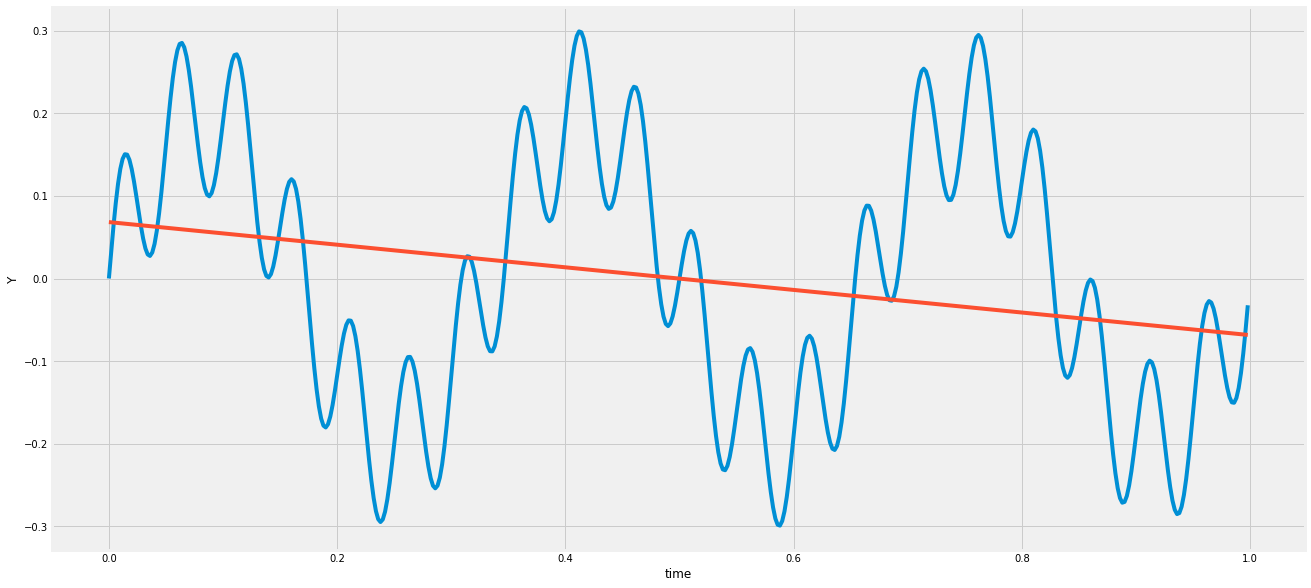

In [3]:
# create time index (between 0 and 1) with same number of time points as sample dataset. Assume we have 2 months time scale
Nt = 500
time_index = np.linspace(0,1-(1/Nt),Nt)

# sample time series with cycles at 10 times per month and 1.5 times per month in the form sin(2*t*pi*f)
x1 = 0.1 * np.sin(2*time_index*np.pi*20) + 0.2 * np.sin(2*time_index*np.pi*3)

# x1 = 0.6 * time_index + 0.1 * np.sin(2*time_index*np.pi*20) + 0.2 * np.sin(2*time_index*np.pi*3)

y = x1.reshape((-1, 1))
x = time_index.reshape((-1, 1))
model = LinearRegression().fit(x, y)
y_pred = model.predict(x)
plt.figure(figsize=(20,10))
plt.plot(time_index, x1)
plt.plot(time_index, y_pred)
plt.xlabel('time')
plt.ylabel('Y')
plt.show()

# 1. Fourier

We need a way to represent time series in terms of fundamental basis functions. Ideally we need to be able to represent ANY time series with these basis functions. 


Fourier's theorem states that any periodic waveform may be represented as an infinite sum of sines and cosines (recall that cosine is a sine wave shifted in phase by 90 degrees).

What are the applications of Fourier's theorem? 

- EQ and audio filtering
- image and video codecs
- general signal processing (e.g. communications, speech recognition, radio)
- analysis of periodic data (e.g. astrophysics, chemistry, X-ray crystallography, economics,)
- etc.

We make an assumption that our time series is periodic (even if it isn't) in order to decompose it into sines and cosines. Let's see if we can represent a square wave using only sine waves... 

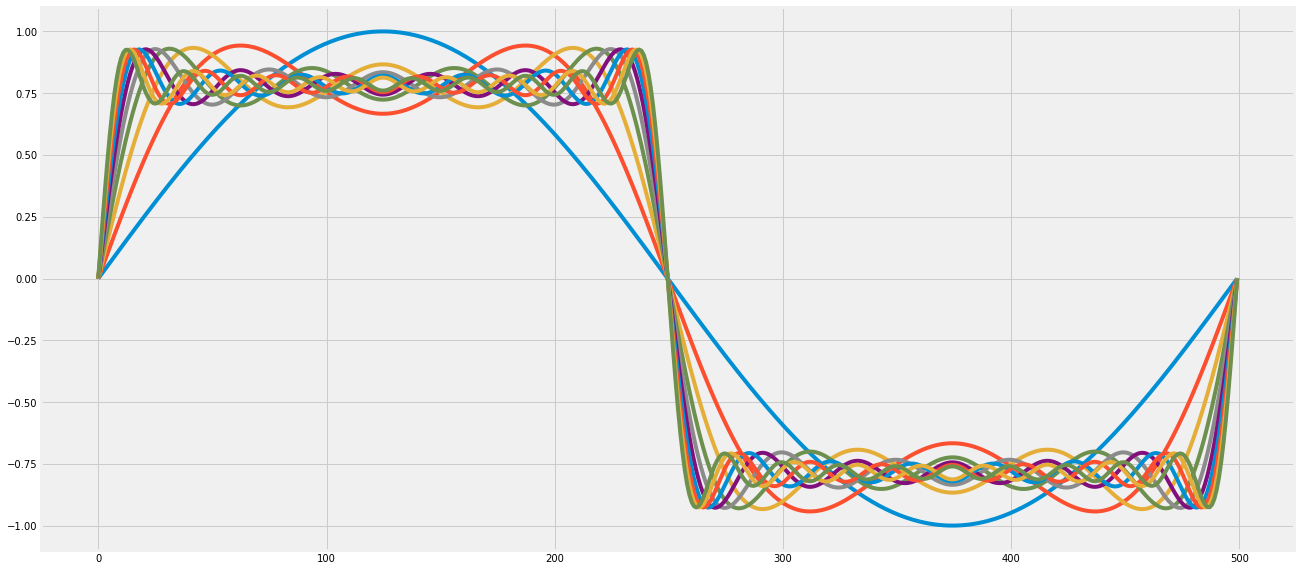

In [4]:
# this shows the cumulative sum of sine waves of increasing order
num_sines = 10
points = 500
t = np.linspace(0,2*np.pi,points)
y = np.zeros((num_sines,len(t)))
x = np.zeros(len(t));

for k in range(0,num_sines):
   x += np.sin(((2*k)+1)*t)/((2*k)+1)
   y[k,:] = x
    
plt.figure(figsize=(20,10))
for i in range(0, num_sines):
    plt.plot(y[i,:])
     
plt.show()

We are using sine waves as basis functions to represent our time series. In the limit, we experience 'Gibb's phenomenon' which affects our ability to represent discontinuities. In practice this is not an issue.

The spectral 'coefficients' are the amplitudes of the sines and cosine waves in this series.

Let's say we have a theory that some variable Y varies once a month, and we have 60 days worth of data, sampled once daily.

In [8]:
# create time index (between 0 and 1) with same number of time points as sample dataset. 
# Assume we have 2 months time scale
Nt = 60
time_index = np.linspace(0,1-(1/Nt),Nt) # this puts our x axis in arbitrary time units of 1/60 
Fs = 30 # sampling frequency in samples per month


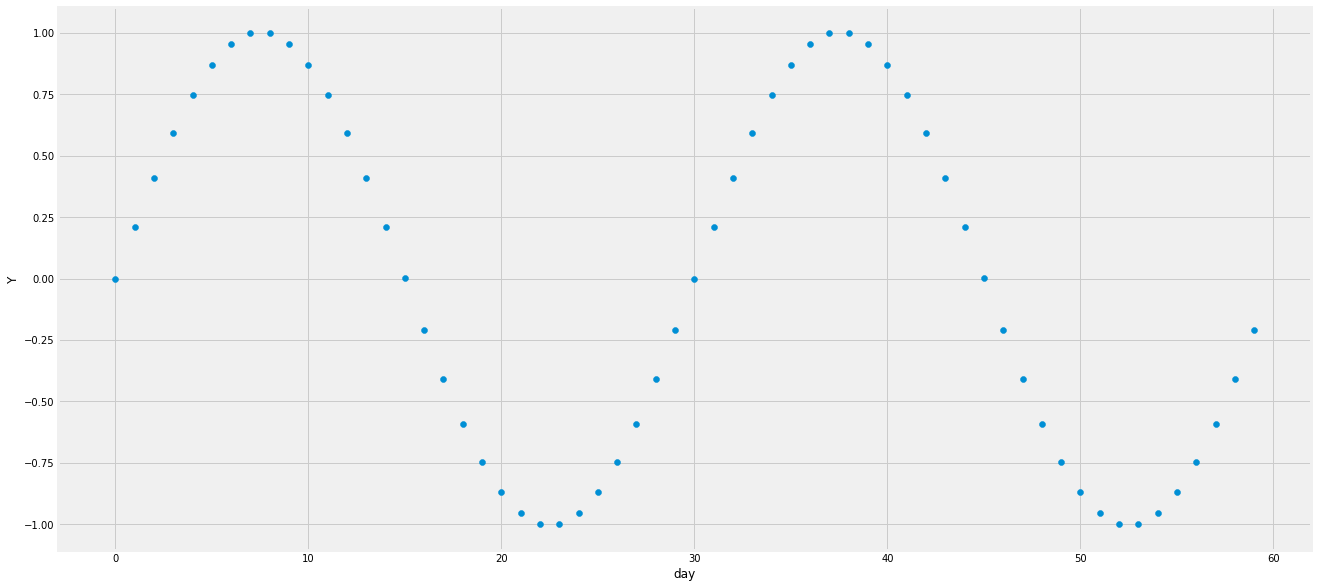

In [15]:
# sample time series with cycles at once per month
x1 = np.sin(2*time_index*np.pi*2)

# see what happens if you add noise? 
# x1 = np.sin(2*time_index*np.pi*2) + 0.2 * np.random.randn(len(time_index))

# rescale to be between -1 and 1
x1 = 2 *( x1-x1.min())/(x1.max() - x1.min()) - 1
plt.figure(figsize=(20,10))
plt.scatter(time_index*Nt,x1)
plt.xlabel('day')
plt.ylabel('Y')
plt.show()

Note that there is no 'phase offset to this'. If we want to, say, delay the rise of the wave (at this SPECIFIC frequency) by 5 days, then we need to understand the relationship between 5 days and the total period of the wave of 2*pi. e.g. our period is 30 days (frequency is once per month = 2*pi) then 5 days is 5/30 * 2pi.

The important thing to understand here is that 'phase' is specific to the wave, not the overall time series. If we want to delay the entire timeseries, then we add our shift to 'time_index' directly. 

In [16]:
days_delay = 15 # for specific frequency
# sample time series with cycles at once per month
x2 = np.sin(2*time_index*np.pi*2 - (days_delay/30)*2*np.pi ) 

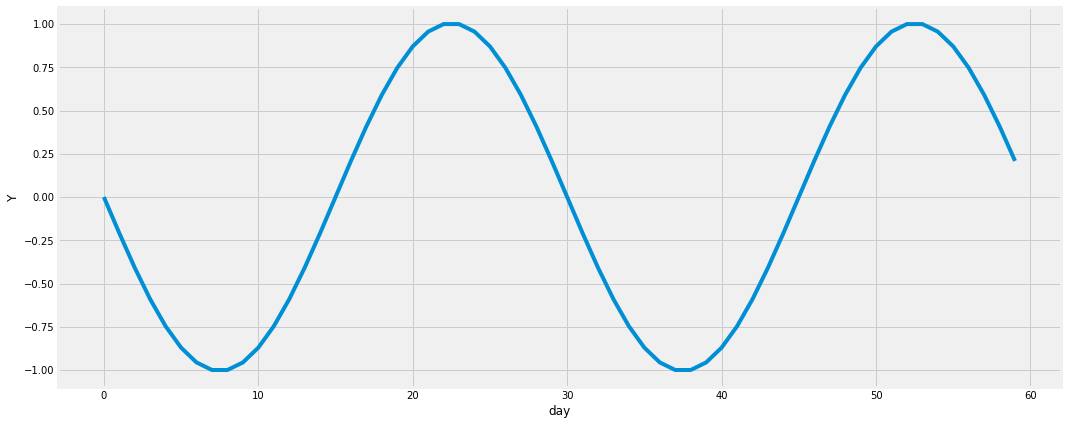

In [17]:
# rescale to be between -1 and 1
x2 = 2 *( x2-x2.min())/(x2.max() - x2.min()) - 1
plt.figure(figsize=(16,7))
plt.plot(time_index*Nt,x2)
plt.xlabel('day')
plt.ylabel('Y')
plt.show()

See above that the rise of our wave has now been delayed by days_delay. 

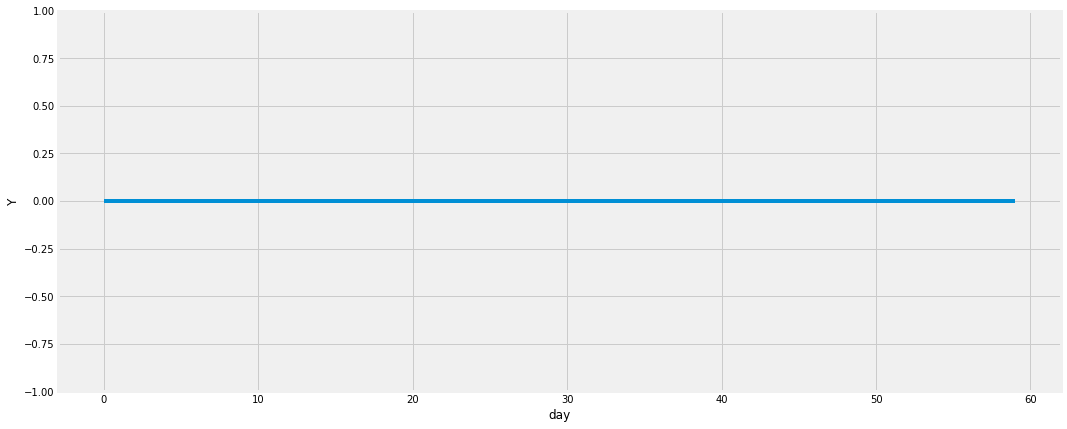

In [22]:
# if the waves are in inverse polarity (i.e. pi radians out of phase) they will completely cancel:
plt.figure(figsize=(16,7))
plt.plot(time_index*Nt,x2+x1)
plt.xlabel('day')
plt.ylabel('Y')
plt.ylim(-1,1)
plt.show()

# notice the y-axis scale!!

# 2. Spectral Analysis with FFT
Now let's use an algorithmic implementation of the 'Fourier Transform' to decompose our time series into its constituent sine and cosine coefficients. This tells us which frequencies are in our wave. This TRANSFORM is not destroying information, just transforming it from the time domain to the frequency domain. We move from *time series* to *frequency spectrum*.

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15. ]
(31,)
(60,)
fft output shape:  (60,)
(31,)


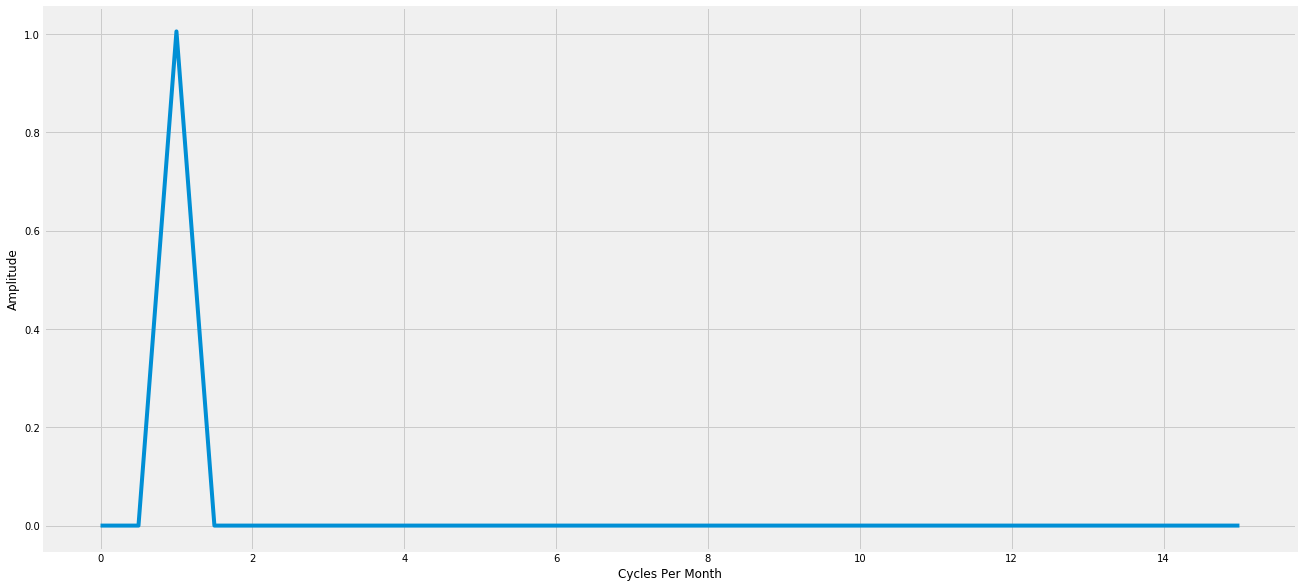

In [24]:
Nt = 60
Fs = 30 # sampling frequency in samples per month
f = Fs * np.linspace(0,int(Nt/2), int(Nt/2+1))/Nt
print(f)
print(f.shape)
fft1 = np.fft.fft(x1)
print(x1.shape)
print('fft output shape: ', fft1.shape)
fft2 = 2*np.abs(fft1[0:int(Nt/2)+1]/Nt)
print(fft2.shape)
plt.figure(figsize=(20,10))
plt.plot(f, fft2)
plt.xlabel('Cycles Per Month')
plt.ylabel('Amplitude')
plt.show()

In [25]:
(fft1[0:int(Nt/2)+1])


array([ 2.10942375e-15+0.00000000e+00j, -2.18487513e-15+2.33053387e-15j,
       -1.13242749e-14-3.01652484e+01j, -9.87904418e-17-5.41537189e-15j,
        1.77978211e-16-1.33463390e-15j, -9.03052588e-16-1.96281790e-16j,
       -2.25039801e-15-1.80715635e-15j,  2.26231003e-15-3.72411319e-15j,
       -9.29237909e-17-1.20220381e-15j, -1.30085518e-15-8.09096358e-16j,
       -8.80207377e-16+0.00000000e+00j,  3.57623228e-15-3.79035563e-15j,
        9.51788539e-16-7.60408786e-16j, -1.79614209e-15-2.44188544e-15j,
        5.42721908e-16-3.13684422e-15j,  2.99760217e-15-2.44249065e-15j,
       -9.12528124e-17+1.49489122e-16j,  6.60309782e-16-2.72905594e-15j,
        2.51478755e-15+4.10679141e-16j, -4.13906014e-16-1.97489751e-16j,
        9.43689571e-16-8.65333209e-16j,  1.40186661e-15-1.13452422e-15j,
        5.59865001e-15+1.77635684e-15j, -2.42016242e-15+1.85909263e-15j,
        1.32416866e-15-2.07507514e-15j, -1.09534886e-15-5.80874327e-16j,
        1.95510159e-15-2.83951501e-15j,  1.44106895

See above that we have 1 spike at a frequency of once per month (care needs to be taken in setting the x-axis units). Decide on a metric and stick to it. We have gone with 'cycles per MONTH'.

Note, also, the operations. It is not critical to understand this, but the FT gives an 'even' spectrum (one which is mirrored around the 'y' axis) and it also gives complex coefficients (with imaginary numbers). We therefore take only one half of the spectrum, take the ABS value, and multiply it by 2 to compensate for the fact we lost half the energy when taking only half the spectrum.

What happens if our signal does not have a full number of cycles (i.e. it contains discontinuities) like this:

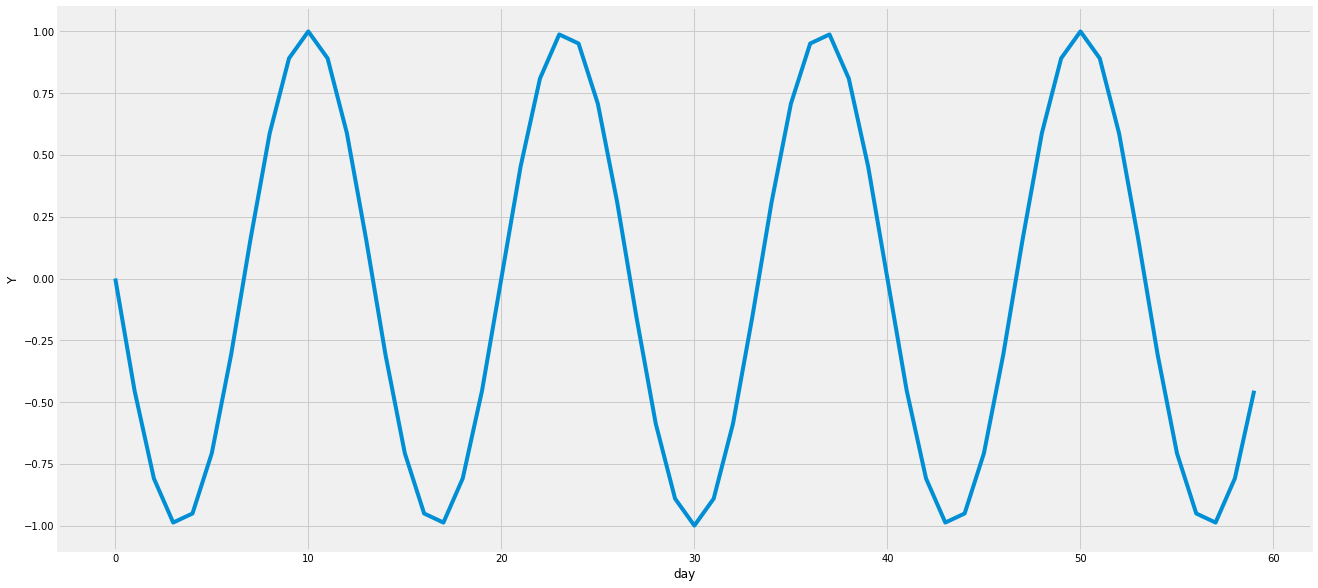

In [26]:
# sample time series with cycles at once per month
x1 = np.sin(2*time_index*np.pi*4.5 - (days_delay/30)*2*np.pi ) 
# and see what happens if we add noise 
# x1 = np.sin(2*time_index*np.pi*4.5 - (days_delay/30)*2*np.pi ) + 0.2*np.random.randn(len(time_index))

# rescale to be between -1 and 1
x1 = 2 *( x1-x1.min())/(x1.max() - x1.min()) - 1
plt.figure(figsize=(20,10))
plt.plot(time_index*Nt,x1)
plt.xlabel('day')
plt.ylabel('Y')
plt.show()

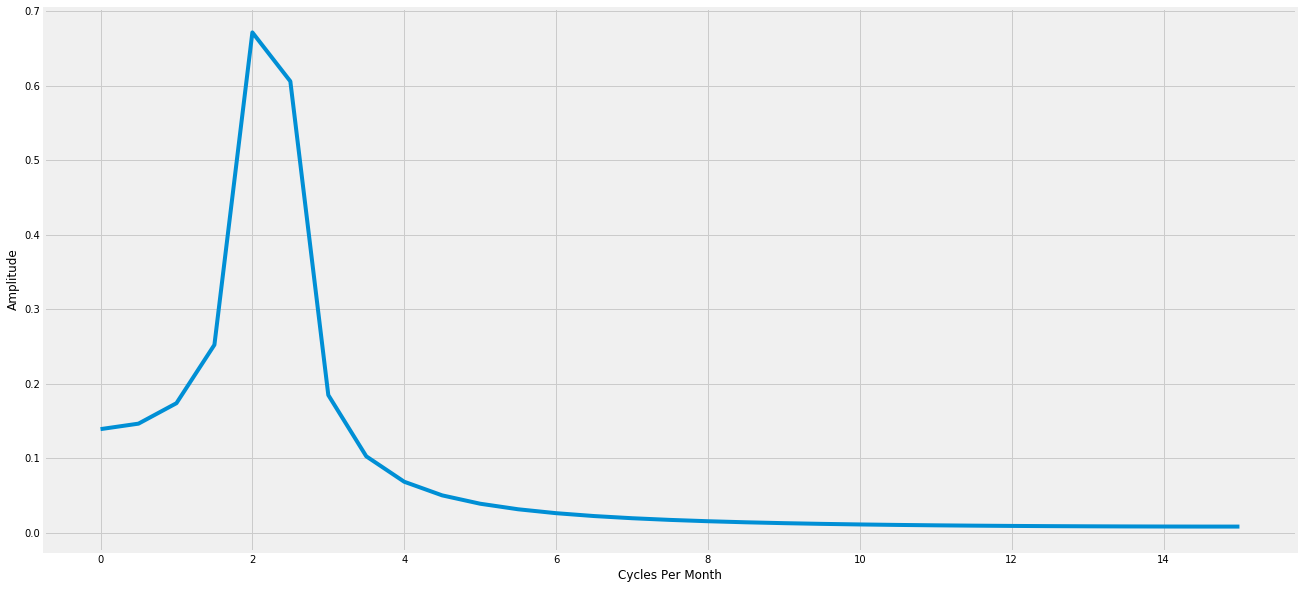

In [27]:

f = Fs * np.linspace(0,int(Nt/2), int(Nt/2+1))/Nt
fft1 = np.fft.fft(x1)
fft2 = 2*np.abs(fft1[0:int(Nt/2)+1]/Nt)
plt.figure(figsize=(20,10))
plt.plot(f, fft2)
plt.xlabel('Cycles Per Month')
plt.ylabel('Amplitude')
plt.show()

See now that the spectrum is more ambiguous. Remember the square wave which had lots of discontinuities? The same thing is happening here. We need many more frequencies to represent this wave. WE might know it is only a sine wave, but the algorithm has to transform exactly what it sees... To deal with this we use WINDOWING but this is a compromise. We will come back to this later.

Now let's see what happens with a more complex wave...

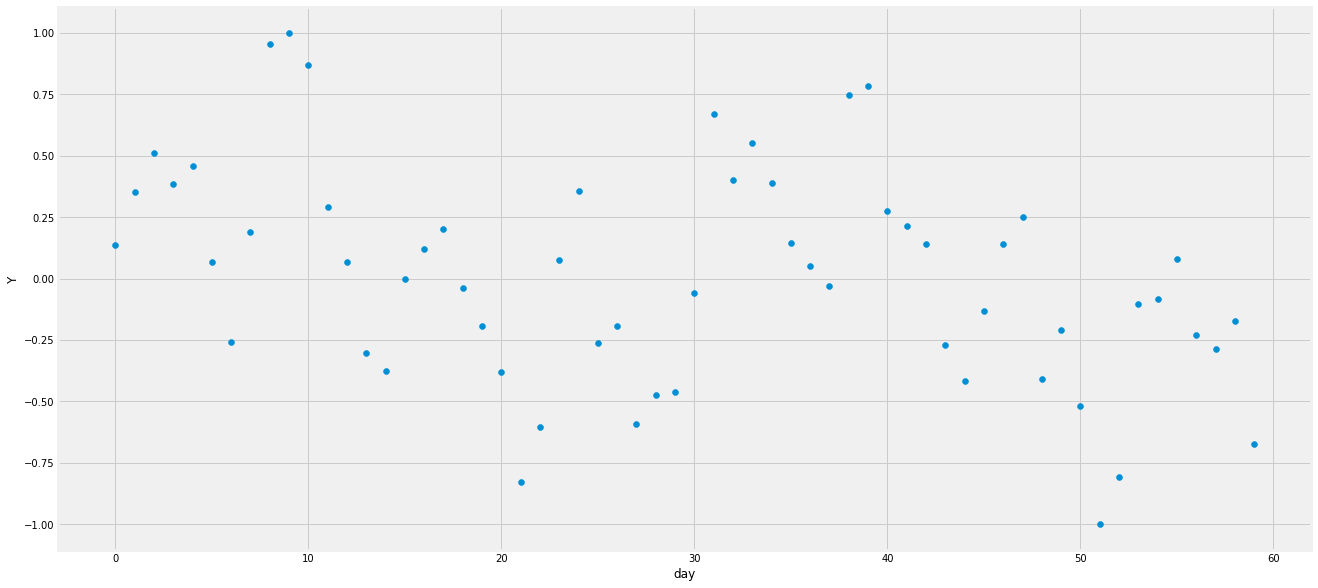

In [73]:
# sample time series with cycles at once per month, 4 times per month and twice a week and some noise
x1 = np.sin(2*time_index*np.pi*2) + np.sin(2*time_index*np.pi*8) + 0.5*np.sin(2*time_index*np.pi*16) + 0.4*np.random.randn(Nt)
# notice that our once per month is written here as twice every two months, because of our time index,
# which is 60 days of data (i.e. two months) squashed into 0 - 1. 

# rescale to be between -1 and 1
x1 = 2 *( x1-x1.min())/(x1.max() - x1.min()) - 1

plt.figure(figsize=(20,10))
plt.scatter(time_index*Nt,x1)
plt.xlabel('day')
plt.ylabel('Y')
plt.show()

This wave looks very chaotic. Is there order in this chaos?

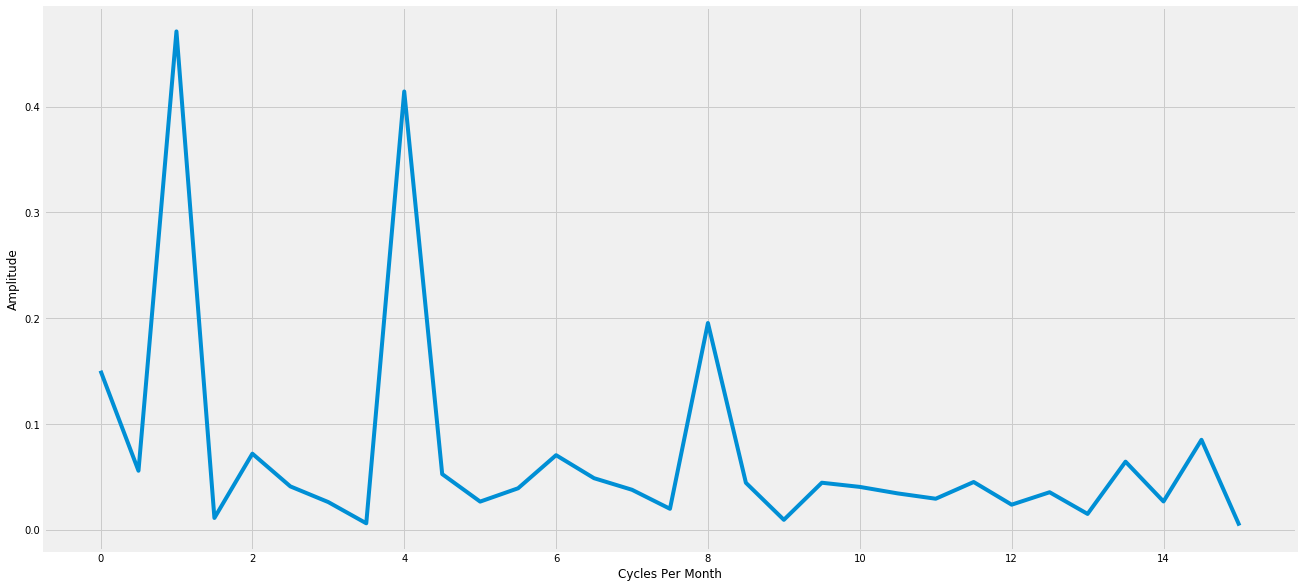

In [45]:
f = Fs * np.linspace(0,int(Nt/2), int(Nt/2+1))/Nt
fft1 = np.fft.fft(x1)
fft2 = 2*np.abs(fft1[0:int(Nt/2)+1]/Nt)
plt.figure(figsize=(20,10))
plt.plot(f, fft2)
plt.xlabel('Cycles Per Month')
plt.ylabel('Amplitude')
plt.show()

Yep... there is! We have recovered the frequencies of once per month, 4 times per month, and twice per week. Note that the more data we have, the more accurate the estimation of the frequency components will be, even if we have the same level of noise/'random variance'.

Note that we can use the inverse FFT to return to the original time series (so long as we KEEP the phase information). This is a therefore TRANSFORM, not a model. No data/information is lost.

# 3. Cross-spectral analysis with FFT

Let's imagine we have two time series, x1 and x2 

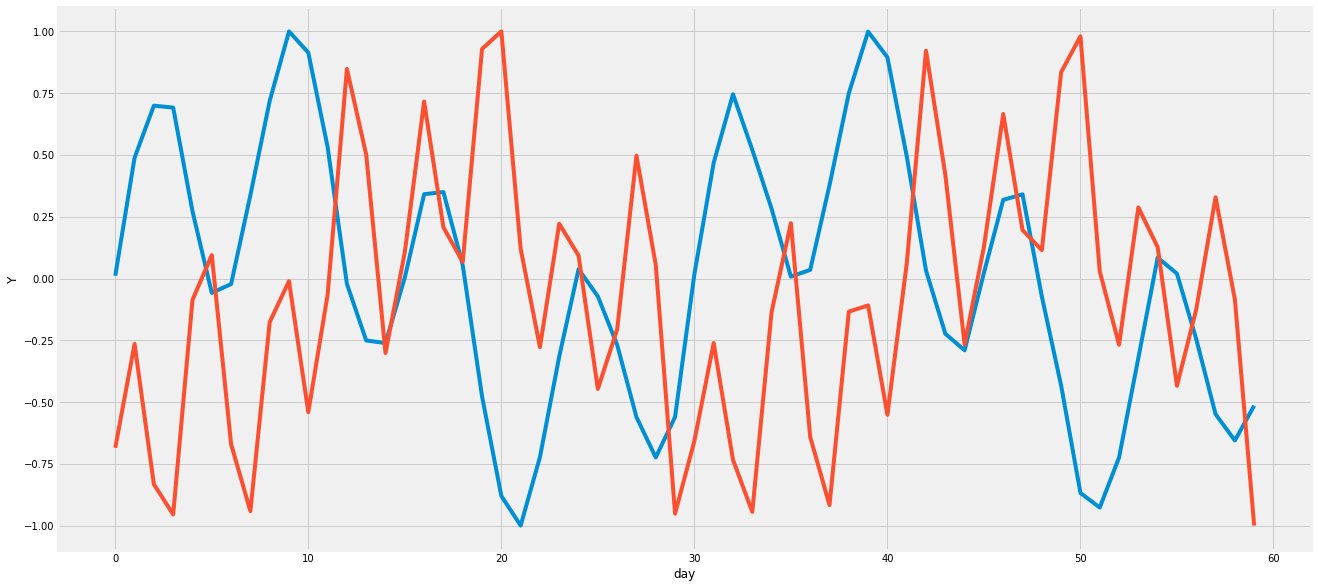

In [49]:
# sample time series both with cycles (once a week and once per month) with phase offset and some noise
# the second series will also have an additional cycle of twice per week

x1 = np.sin(2*time_index*np.pi*2) + np.sin(2*time_index*np.pi*8) + 0.1 * np.random.randn(Nt)

x2 =  np.sin(2*time_index*np.pi*16) + np.sin(2*time_index*np.pi*2 - (10/30)*2*np.pi) + 0.5 * np.sin(2*time_index*np.pi*8 - (10/30)*2*np.pi) + 0.1 * np.random.randn(Nt) 

# rescale to be between -1 and 1
x1 = 2 *( x1-x1.min())/(x1.max() - x1.min()) - 1
x2 = 2 *( x2-x2.min())/(x2.max() - x2.min()) - 1

plt.figure(figsize=(20,10))
plt.plot(time_index*Nt,x1)
plt.plot(time_index*Nt,x2)
plt.xlabel('day')
plt.ylabel('Y')
plt.show()

The two signals share two of the same frequencies (once a week and once per month) apart from the second series which has an additional component. For the components that are shared there are phase offsets. Can we determine that they share the same frequencies after all...?

Yes! CPSD is effectively a measure of correlation in the power spectra of the two signals.
Lets first see what the ffts for the two signals look like:

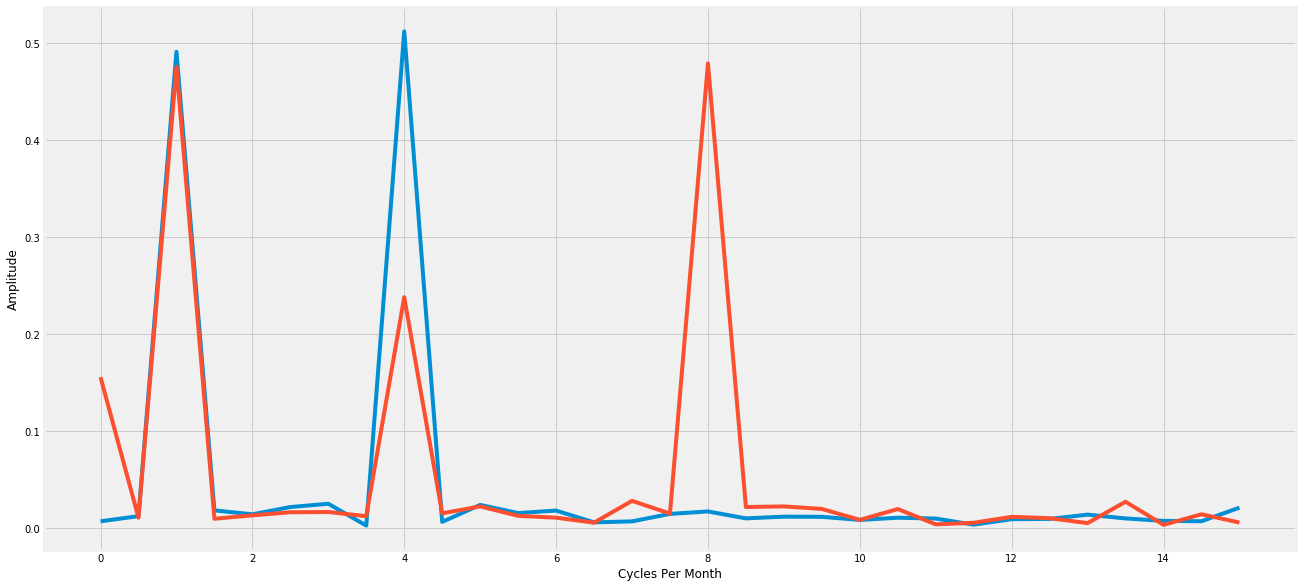

In [16]:
f = Fs * np.linspace(0,int(Nt/2), int(Nt/2+1))/Nt
fft1 = np.fft.fft(x1)
fft2 = 2*np.abs(fft1[0:int(Nt/2)+1]/Nt)
fft3 = np.fft.fft(x2)
fft4 = 2*np.abs(fft3[0:int(Nt/2)+1]/Nt)
plt.figure(figsize=(20,10))
plt.plot(f, fft2)
plt.plot(f, fft4)
plt.xlabel('Cycles Per Month')
plt.ylabel('Amplitude')
plt.show()

We see that the second signal has the additional component at  times per month (or twice per week) that the other series does not. Will this be reflected in the CPSD...? Nope! because it isn't shared between series!

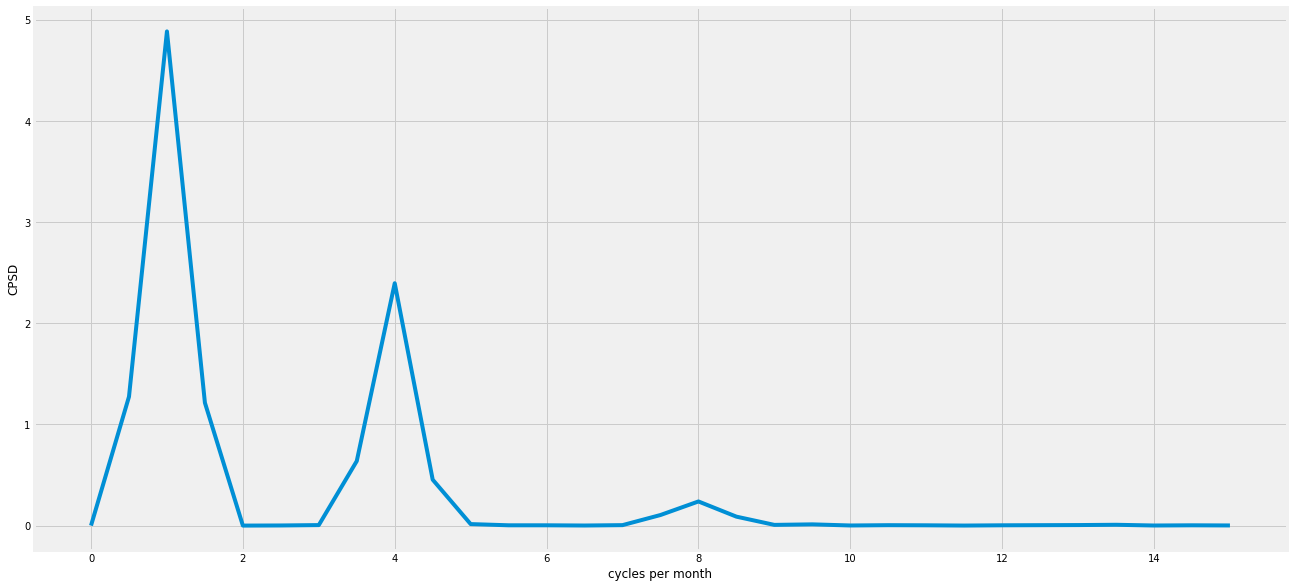

In [17]:
f1, Pxy = signal.csd(x1, x2, nperseg=Nt)
plt.figure(figsize=(20,10))
plt.plot(f, np.abs(Pxy))
plt.xlabel('cycles per month')
plt.ylabel('CPSD')
plt.show()

In [48]:
# what would we get if we took a Pearson's correlation for these two time series?

np.corrcoef(x1,x2)

array([[ 1.        , -0.32575462],
       [-0.32575462,  1.        ]])

# 4. Phase and Polar Histograms

We breifly mentioned (and ignored) the fact that the output of an FFT is complex (i.e. it is in $a + jb$ form) where j is the sqrt(-1). We got around this by just taking the magnitude of $a + jb$ which is $(a^2 + b^2)^{0.5}$. The complex representation has information about the phase:

$\angle (a+jb) = \arctan (b/a) $

but we can also use the numpy.angle() function

In [50]:
fft1 = np.fft.fft(x1) # starting from the original fft...
fft2 = (fft1[0:int(Nt/2)+1]/Nt)  # take the spectrum half that we are concerned with 
# we don't have to worry about the *2 because phase estimates are not affected by amplitude

print(fft2.shape)
fft2

# notice we have 31 complex numbers corresponding with spectral coefficients:

(31,)


array([ 1.40232757e-02+0.00000000e+00j,  4.23889188e-03+2.48308485e-03j,
       -6.24695927e-03-2.56964079e-01j,  3.82448626e-03+5.97777253e-03j,
        9.66401934e-05+2.91526191e-03j, -4.13107188e-04-1.14799334e-03j,
       -1.72057474e-03+3.93009281e-03j,  1.73476442e-03-3.57392909e-03j,
       -5.99681543e-04-2.57663331e-01j, -7.12805597e-03-2.50465671e-04j,
       -1.68005629e-03-2.62014794e-03j, -1.60427342e-03+6.69981422e-04j,
       -4.33205451e-03-2.51245745e-03j,  2.11902988e-03+5.50730613e-03j,
       -2.49930600e-03+2.38540455e-03j, -4.24516358e-03+6.20314531e-03j,
       -2.11323701e-03-5.26339311e-03j,  3.10102963e-03+1.57065219e-03j,
        8.13626471e-03-2.65975981e-03j,  8.85292212e-05-1.94994426e-03j,
        1.89294710e-03-5.42653943e-03j,  3.01126037e-03-3.40859116e-03j,
        3.61131137e-03+3.70320614e-03j,  2.07100030e-03-3.57945218e-03j,
       -2.11063517e-03+1.35726289e-03j, -4.15200413e-03-3.25741108e-03j,
        3.78663398e-05-1.23433750e-03j,  1.43467956

Now we can look at the angles/phase (in $\pi$ RADIANS) for each of the coefficients. But be careful - we only really care about the phase of the components that are of significant amplitude... The rest are noisy.

In [19]:
np.angle(fft2)

array([ 3.14159265,  1.70741728, -1.57690366,  0.80117726,  1.67340221,
        2.05873855, -2.46326441, -0.80666881, -1.58282411, -1.62057937,
        1.37270529,  3.10406343, -0.34527726,  0.00625814, -0.97527548,
        2.8644262 , -1.7124369 ,  1.36067947,  2.62646799, -0.98115149,
        1.52155194,  2.84200373, -0.71645843,  2.12014621,  2.4695456 ,
        0.84490443,  2.58925933, -0.89348336, -1.1929573 , -0.9461966 ,
       -3.14159265])

In order to demonstrate how this can be useful, let's create some data simulating participants that all share the same periodic cyclicity, but that differ in their phase. 

But first... let's just have a think about phase 'wrapping'. $2\pi$ = 6.283... but in terms of our periodic functions, this is the same as 0.  This means that is it potentially incorrect to think of phase discrepancies that differ by $2\pi$ as different from each other. Polar plots can be useful here, and we will use polar histograms to visualise the distribution of phase  for each spectral component.

One more thing - taking the arithmetic mean of phase does not make sense for the same reason it doesn't work to distinguish between a phase of 0 and a phase of $2\pi$. Luckily, circular statistics exists, and we can use circular means.

What follows depicts a typical full workflow of spectral analysis, including spectral averages, cross-spectral averages, polar histograms and circular means.

In [51]:
num_participants = 100 # participants = couples
Nt = 60
Fs = 30
time_index = np.linspace(0,1-(1/Nt),Nt) # this puts our x axis in arbitrary time units of 1/60 
# we can think of these as two groups of individuals who are in a relationship with each other columnwise
males = np.zeros((len(time_index), num_participants))
females = np.zeros((len(time_index), num_participants))

# we will then further subdivide these into couples for whom their once-per-month cycles are offset by x-days phase, 
# and couples for whom their once-per-month cycles are offset by y-days phase. 

x = 15 # 15 corresponds with 180 degrees out of phase (or pi rads)
y = 8 # 8 corresponds with 96 degrees out of phase (or approx pi/2 rads)

for i in range(0, int(num_participants/2), 1):

    males[:, i] = np.sin(2*time_index*np.pi*2) + 0.1 * np.random.randn(Nt)

    females[:, i] =  np.sin(2*time_index*np.pi*2 + ((x/30)*2*np.pi+np.random.randn(Nt))) +  np.sin(2*time_index*np.pi*8)  + 0.1 * np.random.randn(Nt) 


for i in range(int(num_participants/2), num_participants, 1):

    males[:, i] = np.sin(2*time_index*np.pi*2) + 0.1 * np.random.randn(Nt)

    females[:, i] =  np.sin(2*time_index*np.pi*2 + ((y/30)*2*np.pi+np.random.randn(Nt))) +  np.sin(2*time_index*np.pi*8)   + 0.1 * np.random.randn(Nt) 

print(males.shape)
print(females.shape)

(60, 100)
(60, 100)


In [54]:
# normalise the data by individual (i.e. individual mean centre):
for i in range(males.shape[1]):
    males[:,i] = ( males[:,i] - males[:,i].mean() ) / males[:, i].std()
    females[:,i] = ( females[:,i] - females[:,i].mean() ) / females[:, i].std()

FIRST we should double check our data look right:

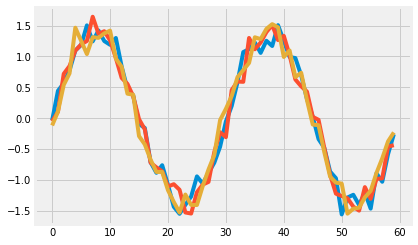

In [55]:
plt.plot(time_index*Nt, males[:,0])
plt.plot(time_index*Nt, males[:,15])
plt.plot(time_index*Nt, males[:,19])
plt.show()

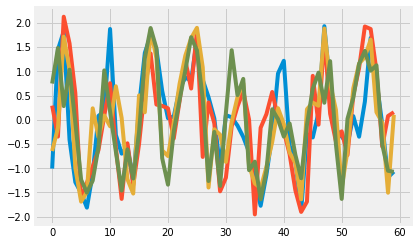

In [56]:
plt.plot(time_index*Nt, females[:,0])
plt.plot(time_index*Nt, females[:,2])
plt.plot(time_index*Nt, females[:,40])
plt.plot(time_index*Nt, females[:,42])
plt.show()

Let's find the average spectra for these groups' series (e.g. we could imagine one group is male and one group is female). NOTE: averaging needs to be done AFTER the absolute values are taken, otherwise phase differences will result in constructive and destructive interference and thereby affect our coefficient averages. 

This first part of the analysis will not be dyadic.

In [57]:
f = Fs * np.linspace(0,int(Nt/2), int(Nt/2+1))/Nt

fft_male1 = np.fft.fft(males, axis=0)

fft_male2 = 2*np.abs(fft_male1[0:int(Nt/2)+1]/Nt)

fft_female1 = np.fft.fft(females, axis=0)

fft_female2 = 2*np.abs(fft_female1[0:int(Nt/2)+1]/Nt)
fft_male2.shape


(31, 100)

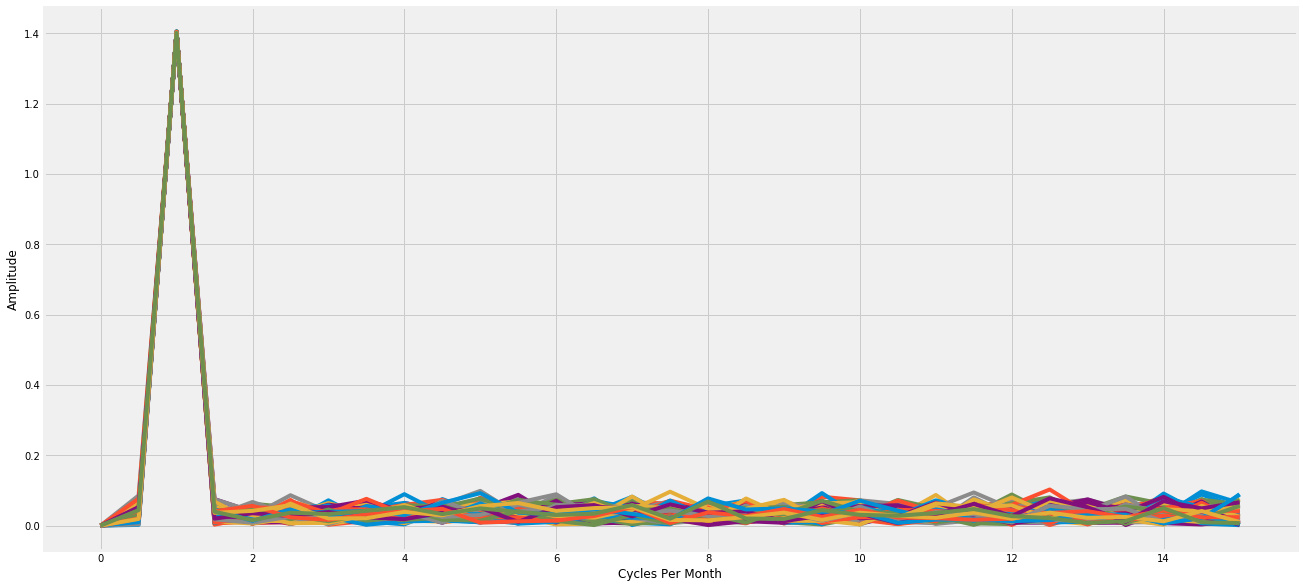

In [58]:
# plot ALL male plots:
plt.figure(figsize=(20,10))
plt.plot(f, fft_male2)
plt.xlabel('Cycles Per Month')
plt.ylabel('Amplitude')
plt.show()

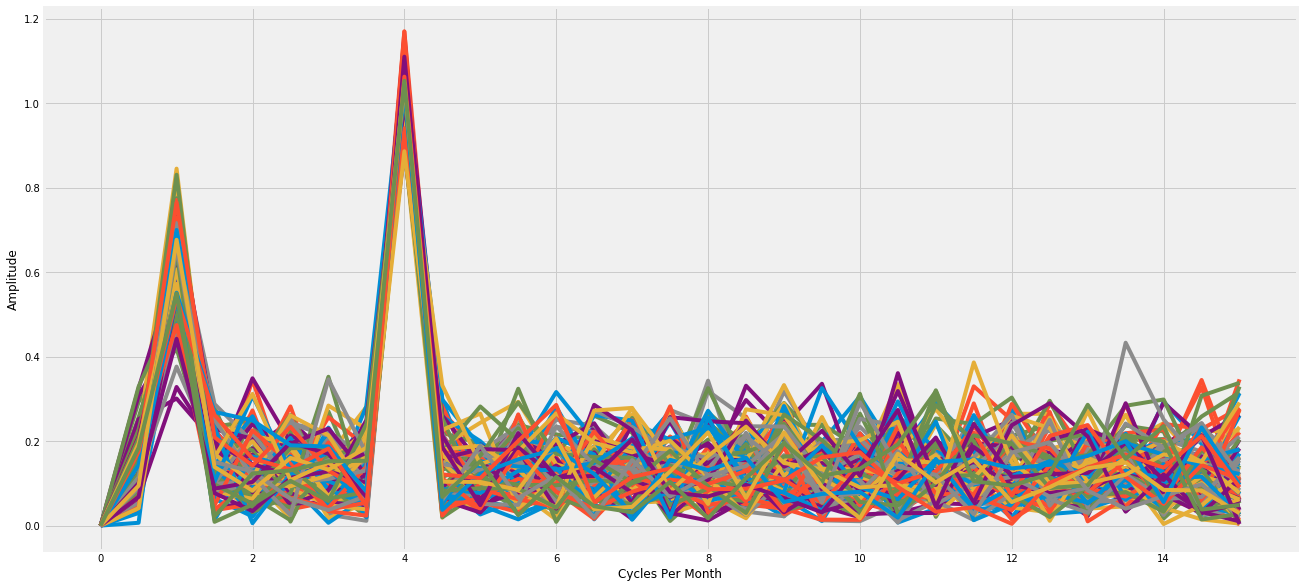

In [59]:
# plot ALL female plots:
plt.figure(figsize=(20,10))
plt.plot(f, fft_female2)
plt.xlabel('Cycles Per Month')
plt.ylabel('Amplitude')
plt.show()

And now let's average these over male/female participants (i.e. columns) and plot.

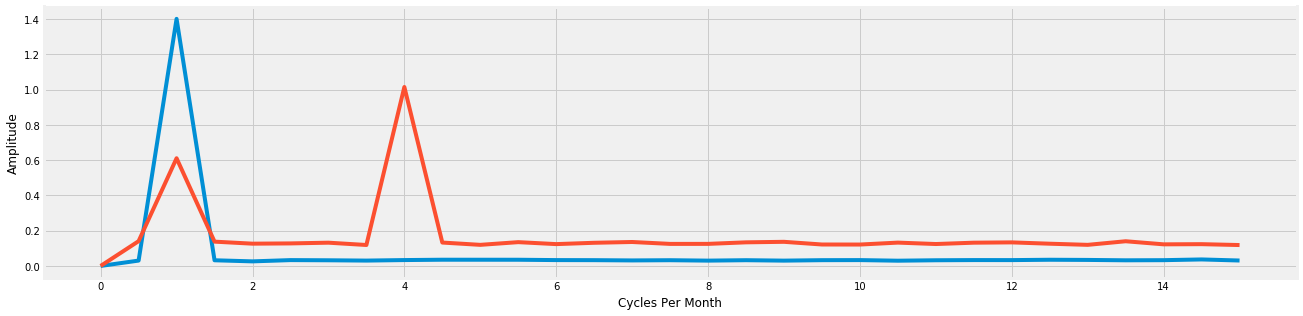

In [60]:
fft_male2_av = np.mean(fft_male2,axis=1)
fft_female2_av = np.mean(fft_female2,axis=1)
plt.figure(figsize=(20, 5))
plt.plot(f, fft_male2_av)
plt.plot(f, fft_female2_av)
plt.xlabel('Cycles Per Month')
plt.ylabel('Amplitude')
plt.show()

Now lets find the average cross spectral plots between COUPLES (i.e. the average CPSD for couples, across all couples).

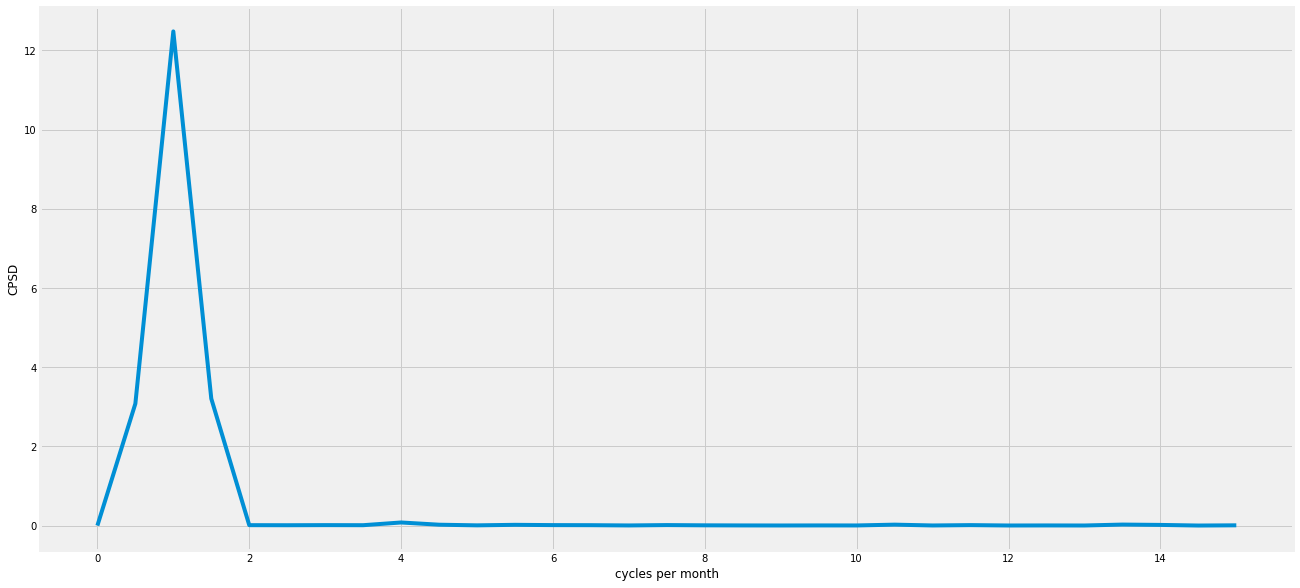

In [61]:
f1, Pxy = signal.csd(males, females, nperseg=Nt, axis=0)

Pxy_mean = np.mean(Pxy, axis=1)

plt.figure(figsize=(20,10))
plt.plot(f, np.abs(Pxy_mean))
plt.xlabel('cycles per month')
plt.ylabel('CPSD')
plt.show()

So far so good, now let's actually look at this phase thing. Remember we split each group of (men and women) into two subgroups - couples that had phase offset x-days, and those with a phase offset of y-days. This phase offset should be reflected in the cpsd.


In [62]:
cpsd_phase = np.angle(Pxy)
for i in range(cpsd_phase.shape[0]):
    for j in range(cpsd_phase.shape[1]):

        if cpsd_phase[i,j] <=0:
            cpsd_phase[i,j] += 2*np.pi

couple_av_phase = circmean(cpsd_phase, axis=1)
# these means tell us the average phase offsets for each frequency between partners (dyadic)

(array([ 9., 24., 16.,  2.,  4., 26., 19.]),
 array([1.09924537, 1.45718355, 1.81512173, 2.17305991, 2.53099809,
        2.88893627, 3.24687445, 3.60481263]),
 <a list of 7 Patch objects>)

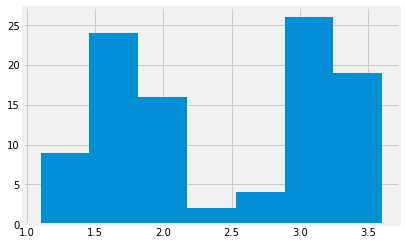

In [63]:
plt.hist(cpsd_phase[2,:], bins=7)

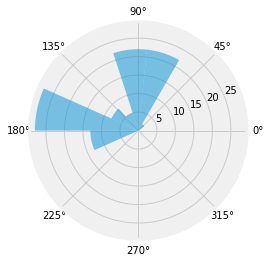

In [64]:
hist_bins = 15  
bins = np.linspace(0, 2 * np.pi, hist_bins + 1)
n, _, _ = plt.hist(cpsd_phase[2], bins)

plt.clf()
w = 2 * np.pi / hist_bins
ax = plt.subplot(1, 1, 1, projection='polar')
pmfs = ax.bar(bins[:hist_bins], n, width=w, bottom=0.0)
for bar in pmfs:
    bar.set_alpha(0.5)
plt.show()

Note that polar histograms are for specific frequencies. If we want to find out what the phase discrepancy corresponds to, we need to know the frequency, and the phase. e.g. for the one above, this is a frequency of 4 times per month, or a period of 7 days, and one the phase discrepancies is approximately 300 degrees. We can do $300/360 * 7 = 5.8$ days discrepancy. The one other thing to be mindful of is the fact that we can understand this as leading OR lagging. 

# 5. Significance...

In order to evade issues with assumptions and parametric distributions, we will take a bootstrapping approach. If any particular spectral component is significant then one would expect the amplitude of the component to be greater than the amplitude of the component for a noise signal.

What does noise look like? If there is no auto-correlation or periodicity (i.i.d.) then a sample from either a uniform distribution or normal distribution will work. Note that this is an important criterion - it is about whether they are i.i.d. and have no auto-correlation that means that the signal is absent from spectral components, not whether it is distributed according to any particular distribution. In fact, in the case of a pure sine wave, the distribution will be bi-modal with highest density at +/- the peak amplitude.

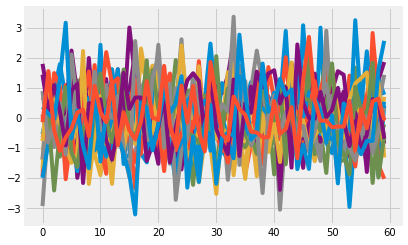

In [66]:
noise_samples = np.random.randn(Nt,20)
plt.plot(noise_samples)
plt.show()

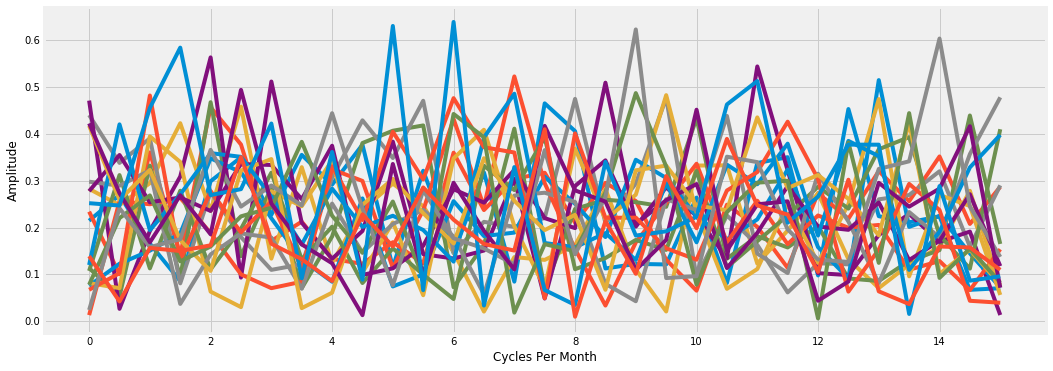

In [67]:
f = Fs * np.linspace(0,int(Nt/2), int(Nt/2+1))/Nt
fft1 = np.fft.fft(noise_samples, axis=0)
fft2 = 2*np.abs(fft1[0:int(Nt/2)+1]/Nt)
plt.figure(figsize=(16,6))
plt.plot(f, fft2)
plt.xlabel('Cycles Per Month')
plt.ylabel('Amplitude')
plt.show()


In the limit, noise contains all frequencies at equal amplitude. See the average below:


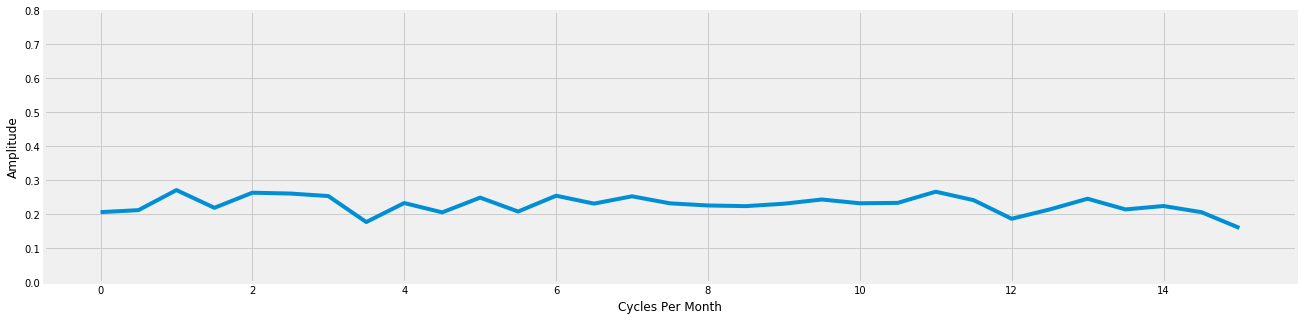

In [68]:
noise_fft_av = np.mean(fft2,axis=1)
plt.figure(figsize=(20, 5))
plt.plot(f, noise_fft_av)
plt.ylim(0,0.8)
plt.xlabel('Cycles Per Month')
plt.ylabel('Amplitude')
plt.show()

Notice how, if we change the number of noise samples, we can get less variance in the average. Bear this in mind for bootstrapping and sample sizes...

If we want to see whether any individual has significant spectral components, we need to randomise it e.g. 1000 times, and compare the FFTs of these randomised series with the FFT of the individual. We can count the number of times the spectral components in our unrandomised FFT fall above (or below...) the corresponding components in each of the randomised FFTs. Let's see how we might code this up:

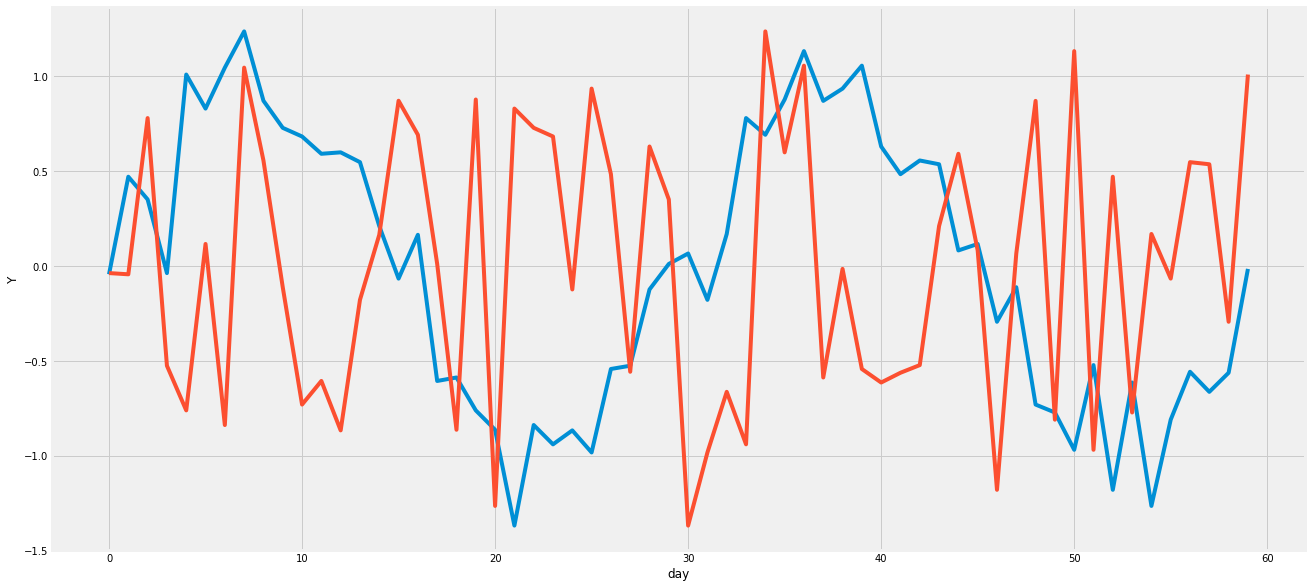

In [76]:
# start with an example time series:
x1 = np.sin(2*time_index*np.pi*2 ) + 0.2*np.random.randn(len(time_index))
x1 = x1 - x1.mean()
# randomise this (we can either do this with or without replacement. It will not affect out spectral results).
x1_rand = np.random.permutation(x1)
x1_rand = x1_rand - x1_rand.mean()

plt.figure(figsize=(20,10))
plt.plot(time_index*Nt,x1)
plt.plot(time_index*Nt,x1_rand)
plt.xlabel('day')
plt.ylabel('Y')
plt.show()

We can see visually that we have destroyed the temporal structure, but it would be nice to confirm this spectrally:

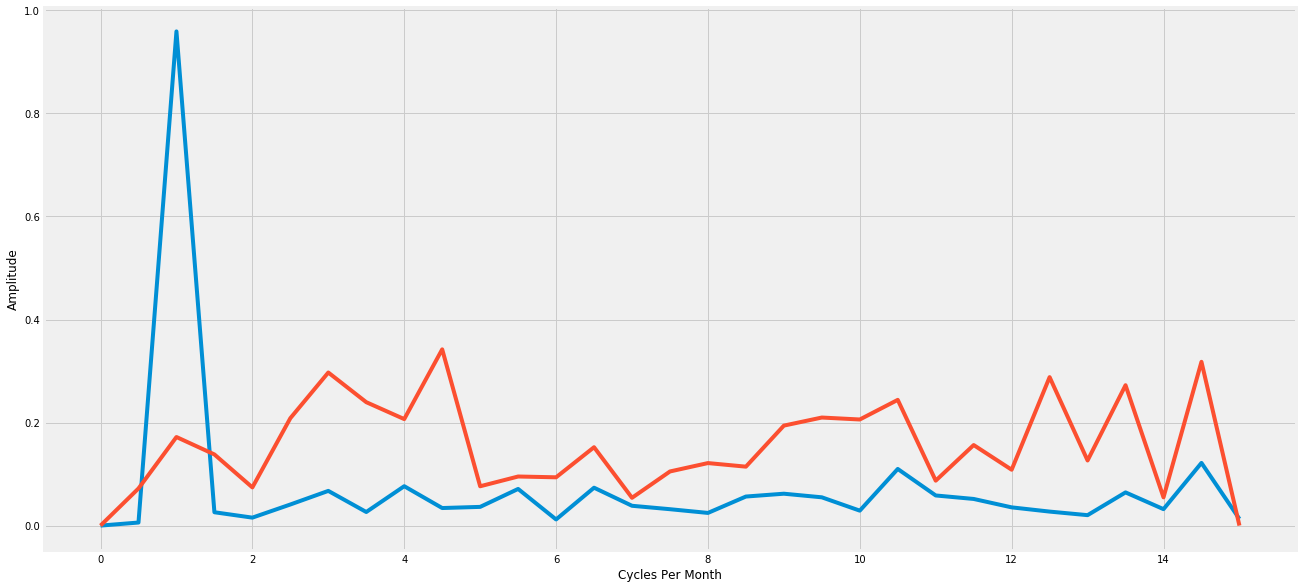

In [77]:
f = Fs * np.linspace(0,int(Nt/2), int(Nt/2+1))/Nt
fft1 = np.fft.fft(x1)
fft2 = 2*np.abs(fft1[0:int(Nt/2)+1]/Nt)
psd1 = np.abs(fft1)**2
fft3 = np.fft.fft(x1_rand)
fft4 = 2*np.abs(fft3[0:int(Nt/2)+1]/Nt)
psd2 = np.abs(fft3)**2
plt.figure(figsize=(20,10))
plt.plot(f, fft2)
plt.plot(f, fft4)
plt.xlabel('Cycles Per Month')
plt.ylabel('Amplitude')
plt.show()

As an aside - we can check the energy in these signals is the same by finding the PSD (abs(fft)**2) and integrating over all values

In [78]:
print(psd1.sum())
print(psd2.sum())

1802.6225390279071
1802.6225390279071


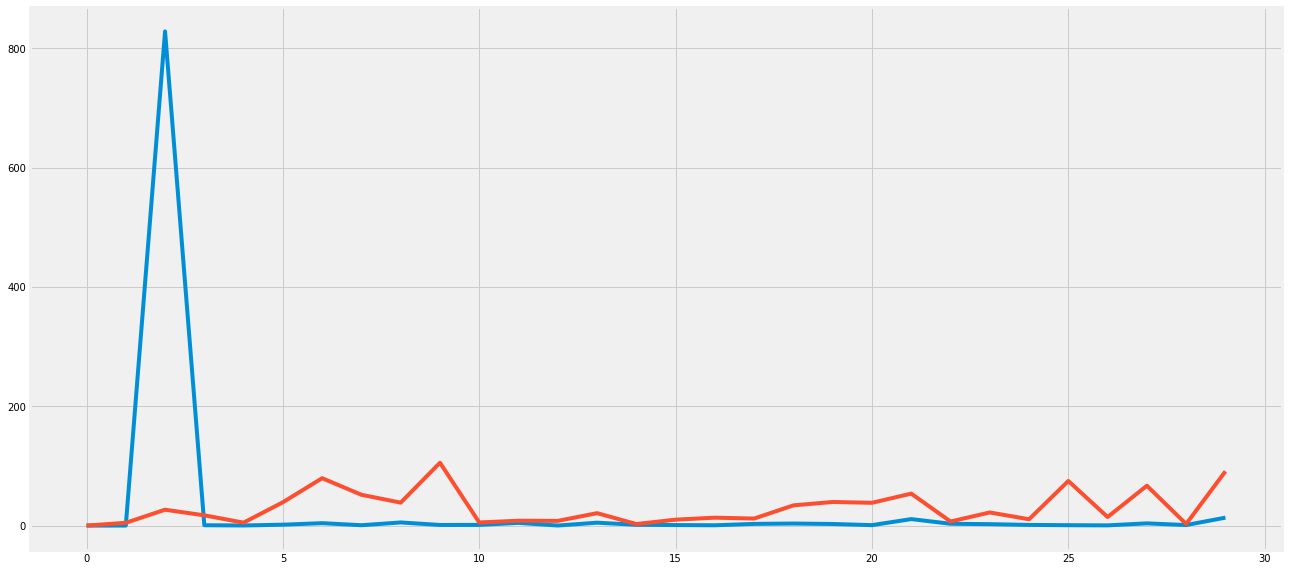

In [80]:
plt.figure(figsize=(20,10))
plt.plot(psd1[0:(int(psd1.shape[0]/2))])
plt.plot(psd2[0:(int(psd1.shape[0]/2))])
plt.show()

Note that if you want proper estimates of energy then it should be scaled according to the frequency spacing, this can be related to the variance in the original signal. But this is tangential.

Now, let's randomise our signal 100 times:

In [81]:
# preallocate memory:
n = 100
x1_rands = np.zeros([len(time_index),n])

for i in range(n):
    x1_rands[:,i] = np.random.permutation(x1)
    
fft_rands1 = np.fft.fft(x1_rands, axis=0)
fft_rands2 = 2*np.abs(fft_rands1[0:int(Nt/2)+1]/Nt)  # compute the ffts for all the randomised signals

fft1 = np.fft.fft(x1)
fft2 = fft2 = 2*np.abs(fft1[0:int(Nt/2)+1]/Nt)

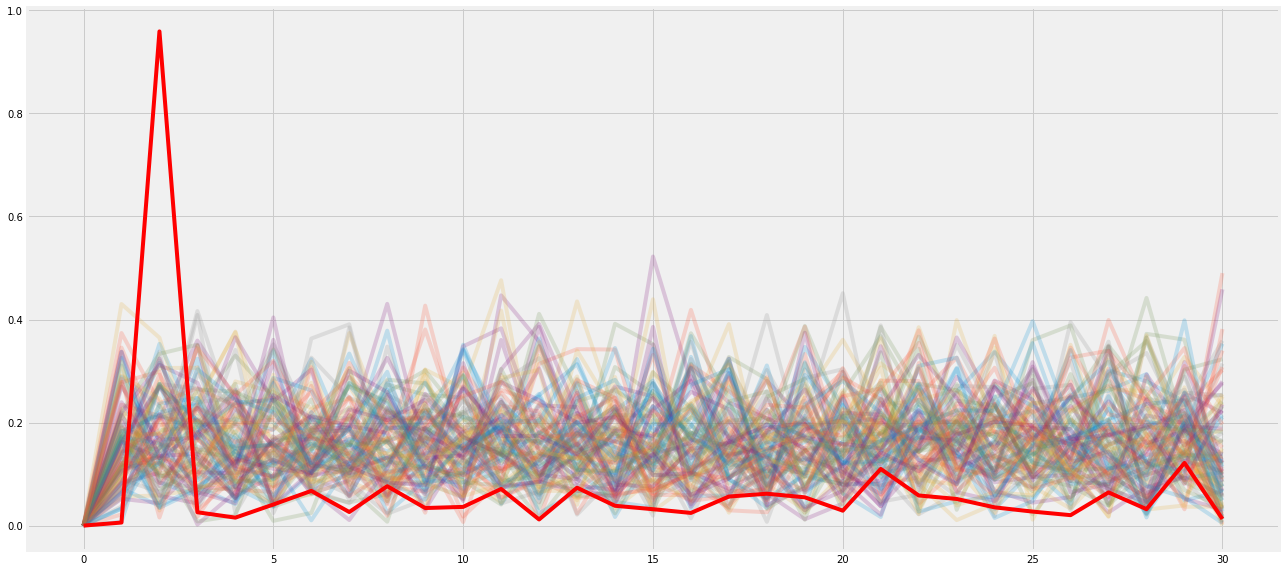

In [82]:
plt.figure(figsize=(20,10))
plt.plot(fft_rands2, alpha=0.2)
plt.plot(fft2, 'r')
plt.show()

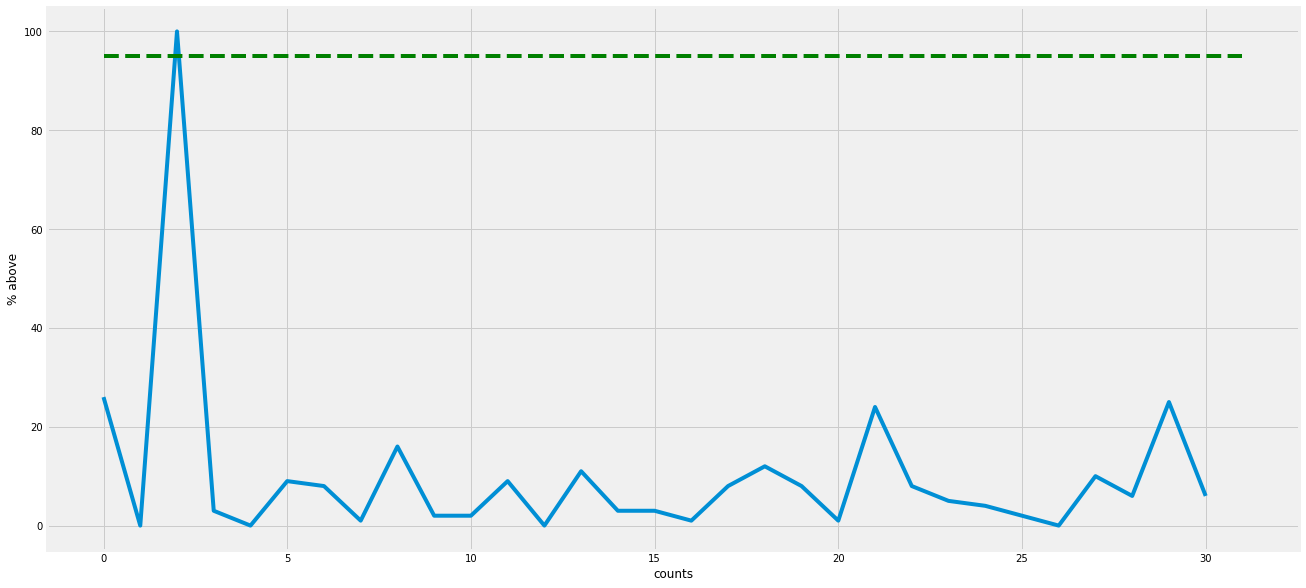

In [83]:
# here is the code for counting the number of times our signal is above the noise signals:

counts = np.zeros(len(fft2))

for i in range(n):
    for j in range(len(fft2)):
        to_compare = fft_rands2[j,i]
        coeff = fft2[j]
        if coeff > to_compare:
            counts[j] += 1
  
counts = counts / n * 100

plt.figure(figsize=(20,10))
plt.plot(counts)
plt.plot(np.linspace(0,len(counts),len(counts)), np.array([95]*len(counts)), 'g--')
plt.xlabel('counts')
plt.ylabel('% above')
plt.show()

We can do this test for the whole group. To do this we follow these steps:
- Find the group average FFT (as we did before)
- Randomise all the group's series and find the group average FFT 'n' times where n is the number of bootstraps (e.g. 10000)
- For each coefficient in the group average FFT (unrandomised) count how many times it falls above the corresponding coefficient across all the randomised FFTs. Convert this number to a percentage.

Something to bear in mind - have a specific hypothethis. Don't go in blind trying to 'show' significance, otherwise we need to adjust for the number of tests we are doing. Effectively we are testing each coefficient for significance in this basic/naiive method demonstrated here. This is to show the principles being applied, but it is not statistically rigorous. 


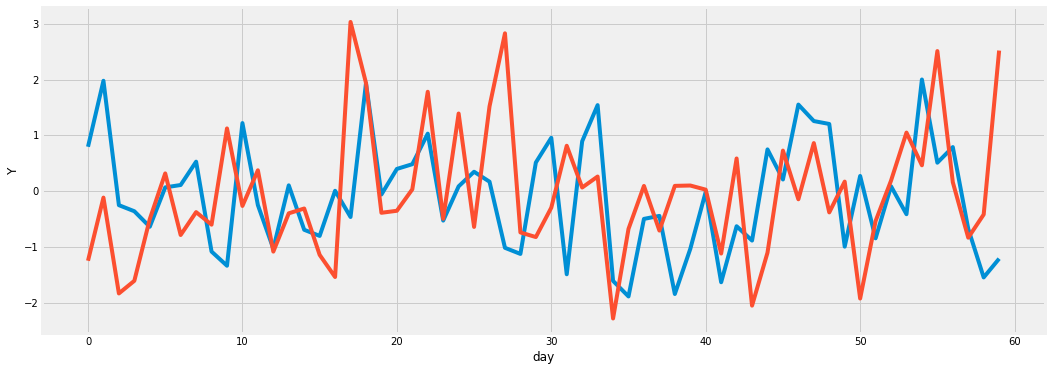

In [84]:
# lets create out group data

num_participants = 100

group = np.zeros((len(time_index), num_participants))

x = 15 # 15 corresponds with 180 degrees out of phase (or pi rads)

for i in range(0, int(num_participants), 1):
    group[:, i] =  0.6*np.sin(2*time_index*np.pi*2 + ((x/30)*2*np.pi+np.random.randn(Nt))) +  0.3 * np.sin(2*time_index*np.pi*8)  + 1 * np.random.randn(Nt) 

# and plot it to check it makes sense:
plt.figure(figsize=(16,6))
plt.plot(time_index*Nt,group[:,3:5])
plt.xlabel('day')
plt.ylabel('Y')
plt.show()

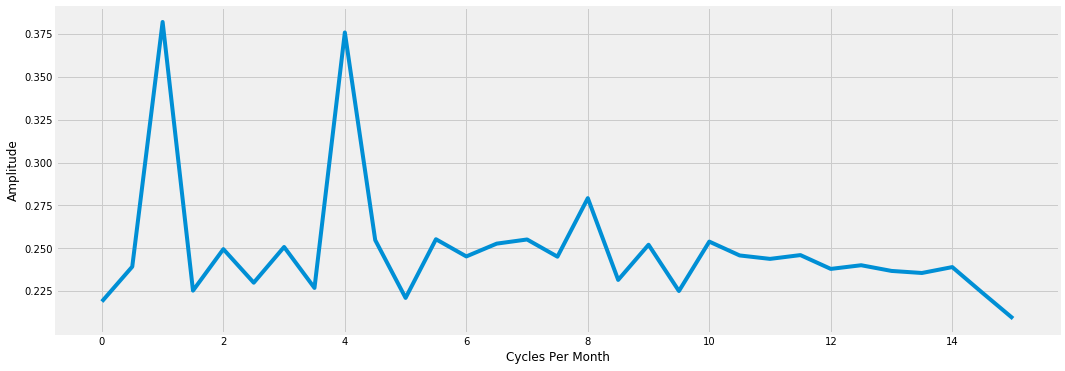

In [85]:
# now get average FFT of this group:

f = Fs * np.linspace(0,int(Nt/2), int(Nt/2+1))/Nt
fft1 = np.fft.fft(group, axis=0)
fft2 = 2*np.abs(fft1[0:int(Nt/2)+1]/Nt)
av_fft = np.mean(fft2,axis=1)
plt.figure(figsize=(16,6))
plt.plot(f, av_fft)
plt.xlabel('Cycles Per Month')
plt.ylabel('Amplitude')
plt.show()

It is worth experimenting with the level of noise in the signals, as well as the number of participants, to see how these things trade off against one another.

Now let us randomise the groups and start the counting!

In [86]:
n = 1000

counts = np.zeros(len(fft2))
for i in range(n):

    ran_group = np.random.permutation(group)
    ran_group_fft1 = np.fft.fft(ran_group, axis=0)
    ran_group_fft2 = 2*np.abs(ran_group_fft1[0:int(Nt/2)+1]/Nt)
    ran_group_av_fft = np.mean(ran_group_fft2,axis=1)

    for j in range(len(av_fft)):
        to_compare = ran_group_av_fft[j]
        coeff = av_fft[j]
        if coeff > to_compare:
            counts[j] += 1

counts = counts / n * 100



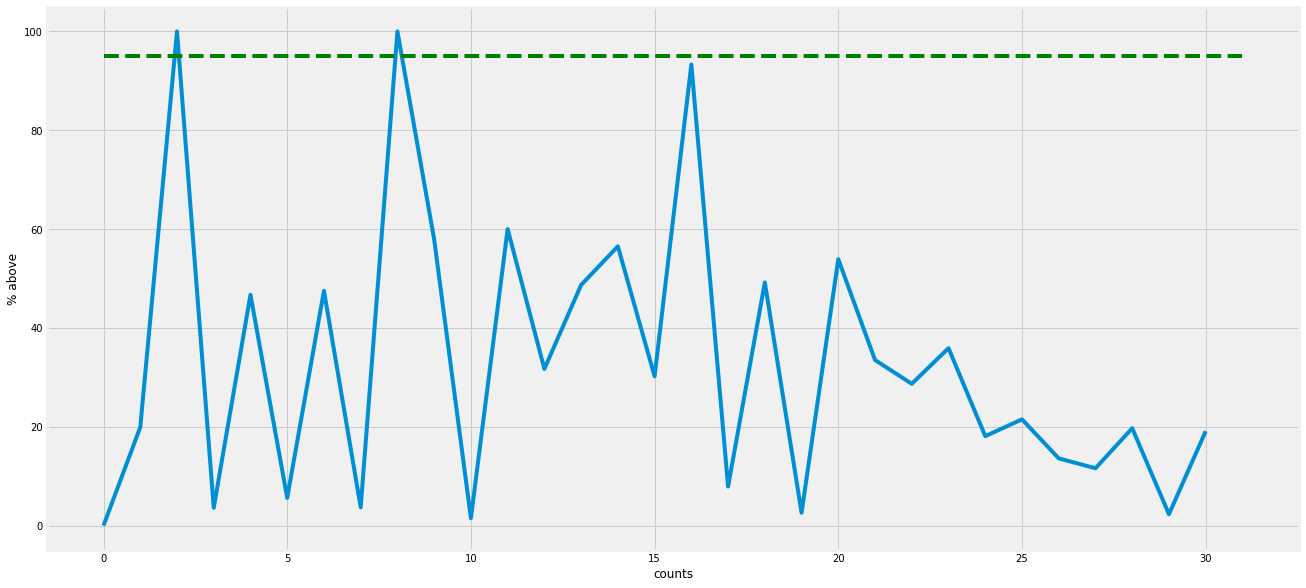

In [87]:
plt.figure(figsize=(20,10))
plt.plot(counts)
plt.plot(np.linspace(0,len(counts),len(counts)),  np.array([95]*len(counts)), 'g--')
plt.xlabel('counts')
plt.ylabel('% above')
plt.show()

Finally - why not consider what happens if we establish significance for coefficients consistently LESS than that of noise? What does this mean? 

We saw that a noise signal has equal energy at all frequencies. What if we have less than the energy of noise at a certain frequency? This means we are less likely than noise to change value at that frequency. This implies auto-correlation, or momentum to the signal.

To compute this, we can literally just swap around the inequality sign of the code, and recompute the counts.